This file is the companion of the article:
IMU Error Modeling Tutorial: INS state estimation and real-time sensor calibration 
authored by 
Jay A. Farrell, Felipe O. Silva, Farzana Rahman, and J. Wendel.
This tutorial is accepted for publication in 
IEEE Control Systems Magazine (referred to below as IEEE CSM)
The articles main point-of-contact is J. Farrell (farrell@ece.ucr.edu)

This software is distributed for academic purposes under the MIT License
 Copyright (c) 2025 JAY A FARRELL
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
 
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
 
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


In [1]:
import ASD_to_GaussMarkovFirstOrder as ASD2GM1
import allantools
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

Fs = 100    # Sampling frequency, Hz
N  = 3.3e-3 # ASD, m/s/s/rtHz = m/s/rtsec
B  = 8e-4   # bias instability, m/s/s 
Tp = 300    # desired delay for the GM ASD peak, seconds
# Create an instance of the ASD_to_GaussMarkovFirstOrder class
gm1 = ASD2GM1.ASD_to_GaussMarkovFirstOrder(N, B, Tp, Fs)

Continuous-time model is (units depend on context): 
	    z(t) = b(t) + n(t),
	db(t)/dt = -6.3000e-03 * b(t) + w(t),
where n(t) is white noise with PSD Sn = 1.0890e-05
and w(t) is the bias process noise with PSD Sw = 2.1162e-08
The steady-state covariance of the bias process is Pb_ss_c = 1.6795e-06.

Discrete-time model is (units depend on context): 
	   z[k] = b[k] + n[k],
	 b[k+1] = 0.9999 * b[k] + w[k],
where n[k] is white noise with covariance Qn = 1.0890e-03
and w[k] is the bias process with PSD Qw = 2.1160e-10.
The steady-state covariance of the bias process is Pb_ss_d = 1.6795e-06.



Simulating discrete-time Gauss-Markov First Order process for duration (seconds): 1000


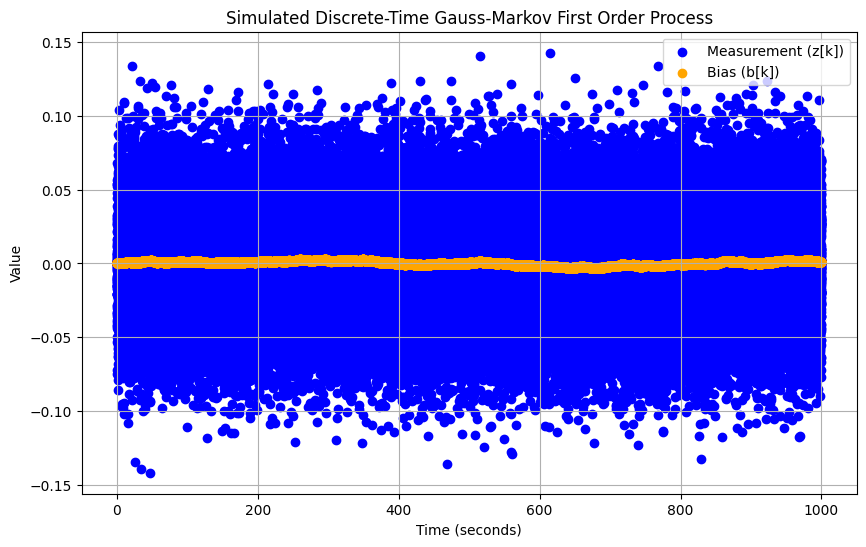

c:\Users\farrell\Documents\GitHub\AV-Matlab-SW\AV_Python\ASD_to_GaussMarkovFirstOrder.py:147: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


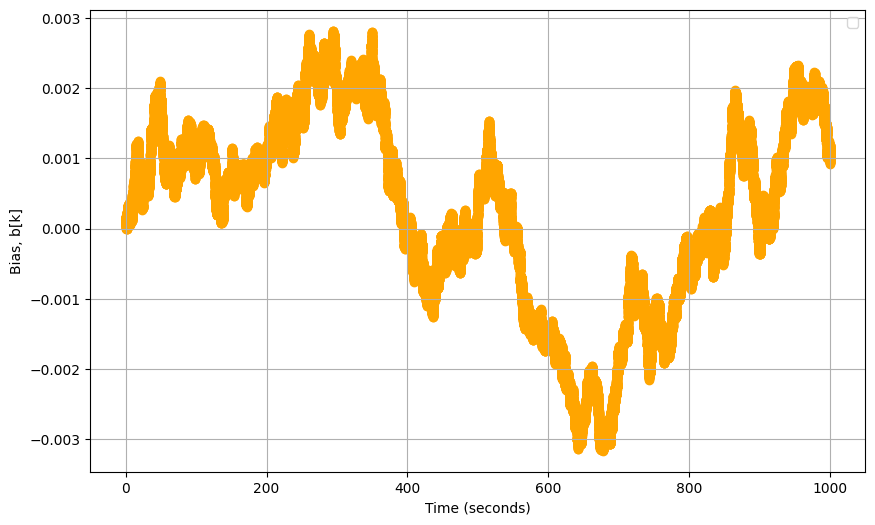

In [2]:
err, bias, rw = gm1.simulate_discrete_time_model(duration=1000, show_plots=True)

(0.0001, 0.1)

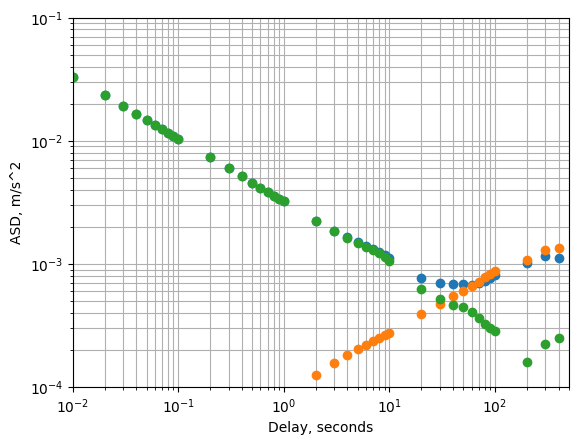

In [ ]:
# Calculate Allan deviation for the IMU data
vals = np.arange(1, 10, dtype=float)  # Create an array of values from 1 to 9
# Define the time intervals for Allan deviation
taus = np.concatenate([0.01*vals, 0.1*vals, vals, 10*vals, 100*vals])  # Concatenate to create a range of taus

tau_err, adev_err, adeverr, n = allantools.oadev(err, rate=Fs, data_type='freq', taus=taus)
#asd_err = np.sqrt(adev)  # Convert Allan deviation to Allan standard deviation (ASD)
tau_bias, adev_bias, adeverr, n = allantools.oadev(bias, rate=Fs, data_type='freq', taus=taus)
#asd_bias = np.sqrt(adev)  # Convert Allan deviation to Allan standard deviation (ASD)
tau_rw, adev_rw, adeverr, n = allantools.oadev(rw, rate=Fs, data_type='freq', taus=taus)
#asd_rw = np.sqrt(adev)  # Convert Allan deviation to Allan standard deviation (ASD)

fig = plt.loglog(tau_err, adev_err, 'o', label='total error')
fig = plt.loglog(tau_bias, adev_bias, 'o', label='bias')
fig = plt.loglog(tau_rw, adev_rw, 'o', label='random walk')
plt.xlabel('Delay, seconds')
plt.ylabel('ASD, m/s^2')
plt.minorticks_on()
plt.grid(which='both', axis='both')
plt.xlim(left=1e-2, right=5e2)
plt.ylim(bottom=1e-4, top=1e-1)
plt.legend()
plt.show()

Loading data from ../AV_Matlab_SW_IEEECSM/parsed_isolated_marble_data_az.mat
acc_z shape: (3634111, 1)


(0.0001, 0.1)

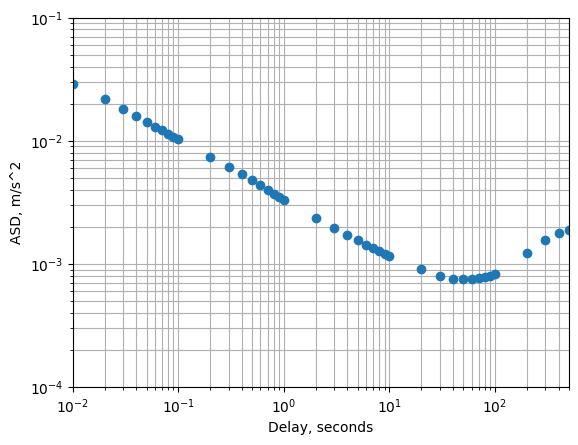

In [ ]:
path = '../AV_Matlab_SW_IEEECSM/parsed_isolated_marble_data_az.mat'
print(f"Loading data from {path}"  )
data = sio.loadmat(path)
acc_z = data['acc_z']
print(f"acc_z shape: {acc_z.shape}")

tau, adev, adeverr, n = allantools.oadev(acc_z, rate=Fs, data_type='freq', taus=taus)
#asd = np.sqrt(adev)  # Convert Allan deviation to Allan standard deviation (ASD)

fig = plt.loglog(tau, adev, 'o', label='Data')
fig = plt.loglog(tau_err, adev_err, 'o', label='total error')
fig = plt.loglog(tau_bias, adev_bias, 'o', label='bias')
fig = plt.loglog(tau_rw, adev_rw, 'o', label='random walk')
#print(f"tau = {tau}, \nadev = {adev}, \nadeverr = {adeverr}, \nn = {n}")
plt.xlabel('Delay, seconds')
plt.ylabel('ASD, m/s^2')
plt.minorticks_on()
plt.grid(which='both', axis='both')
plt.xlim(left=1e-2, right=5e2)
plt.ylim(bottom=1e-4, top=1e-1)
plt.legend()
plt.show()